In [1]:
%cd ..

C:\files\code\projects\dnn-studia\project


In [221]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
pd.set_option('display.max_rows', 200)

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns
sns.set_style("whitegrid")
import zipfile

In [3]:
from pathlib import Path

import os
from config.structure import get_data_sources

dataset_info = get_data_sources(root_path=Path('.'))['stanford']
images_dir = dataset_info['data_dir'] / 'car_ims'

annotations = pd.read_csv(dataset_info['annotations']['csv_file_path'])
annotations

class_names = pd.read_csv(dataset_info['class_names']['csv_file_path'])
class_names.head()

,relative_im_path,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,test
0,car_ims/000001.jpg,112,7,853,717,0,0
1,car_ims/000002.jpg,48,24,441,202,0,0
2,car_ims/000003.jpg,7,4,277,180,0,0
3,car_ims/000004.jpg,33,50,197,150,0,0
4,car_ims/000005.jpg,5,8,83,58,0,0
...,...,...,...,...,...,...,...
16180,car_ims/016181.jpg,38,36,375,234,195,1
16181,car_ims/016182.jpg,29,34,235,164,195,1
16182,car_ims/016183.jpg,25,32,587,359,195,1
16183,car_ims/016184.jpg,56,60,208,186,195,1


,class_names
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


In [6]:
class_count = annotations.groupby('class').relative_im_path.count().to_frame().reset_index()
class_count['class'] = class_count['class'].map(class_names.to_dict()['class_names'])
class_count.rename(columns={'relative_im_path':'count', 'class':'class_name'}, inplace=True)
class_count.head()

,class_name,count
0,AM General Hummer SUV 2000,89
1,Acura RL Sedan 2012,64
2,Acura TL Sedan 2012,86
3,Acura TL Type-S 2008,84
4,Acura TSX Sedan 2012,81


array([[<AxesSubplot:title={'center':'count'}>]], dtype=object)

Text(0.5, 1.0, 'Distribtion of classes in Stanford Cars dataset')

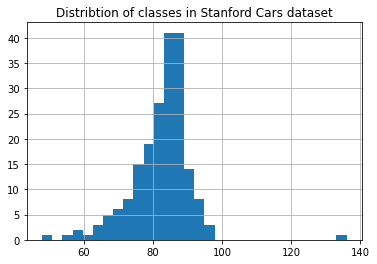

In [90]:
class_count.hist(bins=30)
plt.title('Distribtion of classes in Stanford Cars dataset')
plt.savefig('')

In [209]:
import dataclasses
from models.efficient_net.efficient_nets import EfficientNets

results = dict()
for en in EfficientNets:
    results[en] =dataclasses.asdict(en.value.network_params.compound_scalars)
pd.DataFrame(results).T

,width_coefficient,depth_coefficient,resolution
EfficientNets.b0,1.0,1.0,224.0
EfficientNets.b1,1.0,1.1,240.0
EfficientNets.b2,1.1,1.2,260.0
EfficientNets.b3,1.2,1.4,300.0
EfficientNets.b4,1.4,1.8,380.0
EfficientNets.b5,1.6,2.2,456.0
EfficientNets.b6,1.8,2.6,528.0
EfficientNets.b7,2.0,3.1,600.0
EfficientNets.b8,2.2,3.6,672.0
EfficientNets.l2,4.3,5.3,800.0


# Translations generation

In [202]:
import pandas as pd
from torchvision import transforms
import torchvision
import torch

from PIL import Image
from config.structure import get_data_sources
from datasets.stanford.stanford_cars_data_module import DatasetTypes
from torch.utils.data import DataLoader, Dataset

class StanfordCarsDataset(Dataset):
    def __init__(self, data_directory, annotations, image_size, dataset_type: DatasetTypes, in_channels):
        self.data_directory = data_directory
        self.annotations = annotations
        self.image_size = image_size
        self.dataset_type = dataset_type
        self.greyscale_conversion = in_channels == 1

        is_test = int(dataset_type != DatasetTypes.train)
        self.image_file_names = annotations[annotations.test == is_test].relative_im_path

    def transform(self, image):
        transform_ops = [
            transforms.Resize((self.image_size, self.image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomAffine(25, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=8),
            transforms.ToTensor(),
            transforms.ColorJitter(),
            # transforms.RandomErasing(p=0.5, scale=(0.02, 0.25)),
        ]
        transform_ops = [*transform_ops, transforms.Normalize(
                mean=[0.470, 0.460, 0.455],
                std=[0.267, 0.266, 0.270]
        )]
        
        return transforms.Compose(transform_ops)(image)

    def load_transform(self, image_file_name):
        image_fp = os.path.join(self.data_directory, image_file_name)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        return image

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, index):
        file_name = self.image_file_names.iloc[index]
        image = self.load_transform(image_file_name=file_name)
        return image, torch.as_tensor(
            self.annotations[self.annotations['relative_im_path'] == file_name]['class'].values[0], dtype=torch.long)


in_channels = 3
image_size = 224

dataset_info = get_data_sources(root_path=Path('.'))['stanford']
annotations = pd.read_csv(dataset_info['annotations']['csv_file_path'])
train_data = StanfordCarsDataset(dataset_info['data_dir'], annotations, image_size,
                                 DatasetTypes.train, in_channels)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


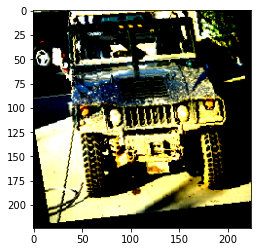

In [203]:
idx = 0
im = train_data[idx][0]
an =  train_data[idx][1]
plt.imshow(im.permute(1,2,0))

# Downloading experiments

In [4]:
import traceback

def get_value_from_logs_with_fallback(logs, name):
    try:
        return logs[name].y
    except:
        traceback.print_exc()
        return None

def get_numeric_channels_value_with_fallback(ex, name):
    try:
        return ex.get_numeric_channels_values(name)[name][0]
    except:
        traceback.print_exc()
        return None
    
def get_numeric_channels_values(ex, names):
    return {name:get_numeric_channels_value_with_fallback(ex, name) for name in names}
    

def get_experiment_metrics(ex):
    ex_metrics = ex.get_numeric_channels_values(*['epoch', 'train_loss', 'val_loss', 'train_acc', 'val_acc'])
    ex_metrics['val_loss'] = ex_metrics['val_loss'].shift(1)
    ex_metrics['val_acc'] = ex_metrics['val_acc'].shift(1)
    ex_metrics = ex_metrics.dropna()
    ex_metrics = ex_metrics.reset_index(drop=True)
    for lr_name in ['lr', 'lr-Adam', 'lr-AdamW', 'lr-SGD']:
        try:
            ex_lr = ex.get_numeric_channels_values(*[lr_name])
            ex_lr.columns = ['x', 'lr']
            ex_metrics = ex_metrics.merge(ex_lr, how='left', left_on='epoch', right_on='x')
        except:
            continue
    return ex_metrics

def download_unzip_artifacts(ex, neptune_out_dir):
    ex.download_artifacts(destination_dir=neptune_out_dir)
    zip_file_path = neptune_out_dir / 'output.zip'
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(neptune_out_dir)
    os.remove(zip_file_path)
    

def download_experiment_info(ex, download_artifacts):
    logs = ex.get_logs()
    metainfo = {**{name: get_value_from_logs_with_fallback(logs, name) for name in ['optimizer', 'optimizer_settings', 'initial_lr', 'scheduler_settings']},
                **get_numeric_channels_values(ex, ['in_channels', 'load_weights', 'custom_dropout_rate'])}
    metainfo['id'] = ex.id
    metainfo['name'] = ex.name
    if download_artifacts:
        download_unzip_artifacts(ex, neptune_out_dir / ex.id)
    return {'metainfo': metainfo, 'ex_metrics': get_experiment_metrics(ex)}

def download_single_experiment(ex, download_artifacts):
    try:
        return download_experiment_info(ex, download_artifacts)
    except:
        print(f'{ex.id} failed')
        traceback.print_exc()
        return None
        
def download_experiments_info(experiments, download_artifacts=True):
    return {ex.id: download_single_experiment(ex, download_artifacts) for ex in tqdm(experiments)}

In [5]:
import neptune
from tqdm import tqdm
neptune_out_dir = Path('data/output/trials/neptune')

project = neptune.init("matkalinowski/sandbox", api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiYzhhMzc3ODktZTNmNi00Zjg2LTgxNDgtNDQwODBiOTg4ZDAzIn0=')
experiments = project.get_experiments()
experiments[:10]

[Experiment(SAN-243),
 Experiment(SAN-248),
 Experiment(SAN-250),
 Experiment(SAN-267),
 Experiment(SAN-272),
 Experiment(SAN-273),
 Experiment(SAN-274),
 Experiment(SAN-283),
 Experiment(SAN-294),
 Experiment(SAN-295)]

In [6]:
relevant_experiments = [ex for ex in experiments if int(ex.id.split('-')[1]) >= 392]
results = download_experiments_info(relevant_experiments)
results['SAN-469']

 25%|██████████████████████████▌                                                                                 | 17/69 [05:38<12:52, 14.85s/it]Traceback (most recent call last):
  File "pandas\_libs\parsers.pyx", line 1141, in pandas._libs.parsers.TextReader._convert_tokens
TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-4-5e285ec1ffed>", line 12, in get_numeric_channels_value_with_fallback
    return ex.get_numeric_channels_values(name)[name][0]
  File "C:\files\code\projects\dnn-studia\project\venv\lib\site-packages\neptune\experiments.py", line 1009, in get_numeric_channels_values
    channels_data[channel_name] = pd.read_csv(
  File "C:\files\code\projects\dnn-studia\project\venv\lib\site-packages\pandas\io\parsers.py", line 686, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "C:\files\cod

{'metainfo': {'optimizer': "<class 'torch.optim.adamw.AdamW'>",
  'optimizer_settings': "{'weight_decay': 0.01}",
  'initial_lr': '1.0E-4',
  'scheduler_settings': "{'patience': 7, 'factor': 0.05}",
  'in_channels': 3.0,
  'load_weights': 0.0,
  'custom_dropout_rate': 0.6,
  'id': 'SAN-469',
  'name': 'efficientnet-b0-9f97df00-006a-11eb-a15d-bd0e2405f7c7'},
 'ex_metrics':          x_x  epoch  train_loss  train_acc   val_acc  val_loss    x_y  \
 0      255.0    0.0    5.307192   0.006127  0.005456  5.280717    0.0   
 1      510.0    1.0    5.241688   0.009436  0.012649  5.267869    1.0   
 2      765.0    2.0    5.201931   0.010784  0.019593  5.165218    2.0   
 3     1020.0    3.0    5.164937   0.014951  0.017981  5.157930    3.0   
 4     1275.0    4.0    5.133021   0.016667  0.021825  5.080748    4.0   
 5     1530.0    5.0    5.100157   0.019363  0.024306  5.079615    5.0   
 6     1785.0    6.0    5.065503   0.024387  0.025918  5.039577    6.0   
 7     2040.0    7.0    5.041481  

In [93]:
results['SAN-469']

{'metainfo': {'optimizer': "<class 'torch.optim.adamw.AdamW'>",
  'optimizer_settings': "{'weight_decay': 0.01}",
  'initial_lr': '1.0E-4',
  'scheduler_settings': "{'patience': 7, 'factor': 0.05}",
  'in_channels': 3.0,
  'load_weights': 0.0,
  'custom_dropout_rate': 0.6,
  'id': 'SAN-469',
  'name': 'efficientnet-b0-9f97df00-006a-11eb-a15d-bd0e2405f7c7'},
 'ex_metrics':          x_x  epoch  train_loss  train_acc   val_acc  val_loss    x_y  \
 0      255.0    0.0    5.307192   0.006127  0.005456  5.280717    0.0   
 1      510.0    1.0    5.241688   0.009436  0.012649  5.267869    1.0   
 2      765.0    2.0    5.201931   0.010784  0.019593  5.165218    2.0   
 3     1020.0    3.0    5.164937   0.014951  0.017981  5.157930    3.0   
 4     1275.0    4.0    5.133021   0.016667  0.021825  5.080748    4.0   
 5     1530.0    5.0    5.100157   0.019363  0.024306  5.079615    5.0   
 6     1785.0    6.0    5.065503   0.024387  0.025918  5.039577    6.0   
 7     2040.0    7.0    5.041481  

In [144]:
def form_experiments_metrics(results, epochs_thr=10):
    experiments_metrics = pd.DataFrame()
    for ex_id in results:
        ex_metrics = results[ex_id]['ex_metrics']
        ex_metrics['ex_id'] = ex_id
        experiments_metrics = pd.concat([experiments_metrics, ex_metrics])
        
    ex_vc = experiments_metrics.ex_id.value_counts()
    experiments_metrics = experiments_metrics[experiments_metrics.ex_id.isin(ex_vc[ex_vc > epochs_thr].index)]
    return experiments_metrics
experiments_metrics = form_experiments_metrics(results)
experiments_metrics

,x_x,epoch,train_loss,train_acc,val_acc,val_loss,x_y,lr,ex_id
0,85.0,0.0,4.216339,0.173480,0.314358,3.238138,0.0,0.001000,SAN-392
1,170.0,1.0,2.231996,0.613872,0.646253,2.140643,1.0,0.001000,SAN-392
2,255.0,2.0,1.609967,0.812573,0.712172,1.893373,2.0,0.001000,SAN-392
3,340.0,3.0,1.361844,0.894828,0.759459,1.757116,3.0,0.001000,SAN-392
4,425.0,4.0,1.238178,0.928603,0.816273,1.563118,4.0,0.001000,SAN-392
...,...,...,...,...,...,...,...,...,...
140,35955.0,140.0,1.016423,0.994363,0.792218,1.688796,140.0,0.000010,SAN-473
141,36210.0,141.0,1.016450,0.994363,0.791722,1.689112,141.0,0.000010,SAN-473
142,36465.0,142.0,1.015356,0.994485,0.791598,1.687602,142.0,0.000010,SAN-473
143,36720.0,143.0,1.015815,0.994118,0.790730,1.688854,143.0,0.000001,SAN-473


In [273]:
experiments_best_score = experiments_metrics.groupby('ex_id').agg({'val_acc': 'max', 'train_acc': 'max'})
experiments_best_score.columns = ['max_val_acc', 'max_train_acc']
experiments_best_score.sort_values(by='max_val_acc',ascending=False, inplace=True)
experiments_best_score

,max_val_acc,max_train_acc
ex_id,,
SAN-396,0.903196,0.998529
SAN-407,0.900552,0.997426
SAN-406,0.899599,0.997794
SAN-398,0.897583,0.997917
SAN-402,0.896917,0.997794
SAN-393,0.896885,0.997917
SAN-401,0.896375,0.998407
SAN-399,0.896336,0.998162
SAN-405,0.896134,0.997647


<AxesSubplot:ylabel='ex_id'>

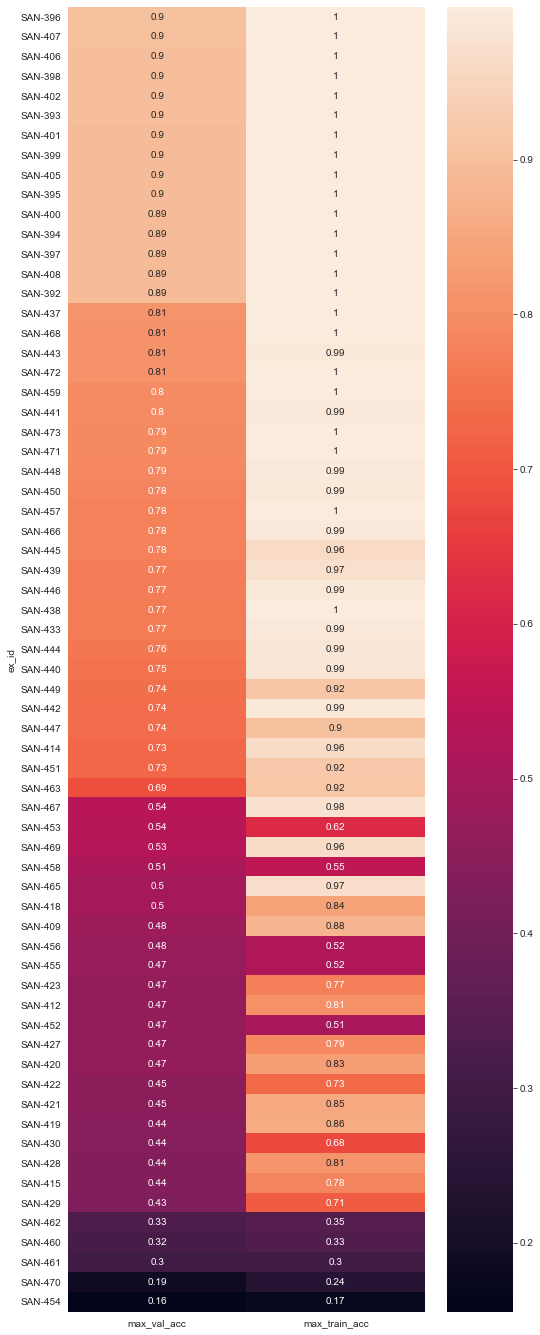

In [457]:
fig, ax = plt.subplots(figsize=[8, 24])
sns.heatmap(experiments_best_score, annot=True)

In [274]:
import json
def column_to_frame(df, colname):
    urolled_column = pd.DataFrame(json.loads(df[colname][0].replace("'", "\"")), index=[0])
    urolled_column.columns = [f'{colname}__{col}' for col in urolled_column.columns]
    del df[colname]
    return pd.merge(df, urolled_column, left_index=True, right_index=True)
    
def unroll_dict_columns(experiment_results):
    df = pd.DataFrame(experiment_results['metainfo'], index=[0])
    df = column_to_frame(df, 'optimizer_settings')
    df = column_to_frame(df, 'scheduler_settings')
    return df
def form_settings_summary(results):
    df = pd.DataFrame()
    for experiment_id in results:
        try:
            df = pd.concat([df, unroll_dict_columns(results[experiment_id])])
        except:
            print(f'{experiment_id=} failed')
            traceback.print_exc()
    df.set_index('id',inplace=True)
    df.index.rename('ex_id',inplace=True)
    return df

settings_summary = form_settings_summary(results)
settings_summary = pd.merge(experiments_best_score, settings_summary, left_index=True, right_index=True)
settings_summary.head()

,max_val_acc,max_train_acc,optimizer,initial_lr,in_channels,load_weights,custom_dropout_rate,name,optimizer_settings__weight_decay,scheduler_settings__patience,scheduler_settings__factor
ex_id,,,,,,,,,,,
SAN-396,0.903196,0.998529,<class 'torch.optim.adamw.AdamW'>,0.001,3.0,1.0,0,efficientnet-b0-82409404-fab3-11ea-bd84-2988f3...,0.01,3,NaN
SAN-407,0.900552,0.997426,<class 'torch.optim.adamw.AdamW'>,0.001,3.0,1.0,0.2,efficientnet-b0-ad2214a2-fb46-11ea-a39a-7dc1e5...,0.20,3,NaN
SAN-406,0.899599,0.997794,<class 'torch.optim.adamw.AdamW'>,0.001,3.0,1.0,0.1,efficientnet-b0-ad2214a2-fb46-11ea-a39a-7dc1e5...,0.20,3,NaN
SAN-398,0.897583,0.997917,<class 'torch.optim.adamw.AdamW'>,0.001,3.0,1.0,0.1,efficientnet-b0-82409404-fab3-11ea-bd84-2988f3...,0.10,3,NaN
SAN-402,0.896917,0.997794,<class 'torch.optim.adamw.AdamW'>,0.001,3.0,1.0,0,efficientnet-b0-82409404-fab3-11ea-bd84-2988f3...,0.20,3,NaN


Learning rate

(<Figure size 1440x864 with 3 Axes>,
 array([<AxesSubplot:xlabel='epoch', ylabel='lr'>,
        <AxesSubplot:xlabel='epoch', ylabel='val_loss'>,
        <AxesSubplot:xlabel='epoch', ylabel='val_acc'>], dtype=object))

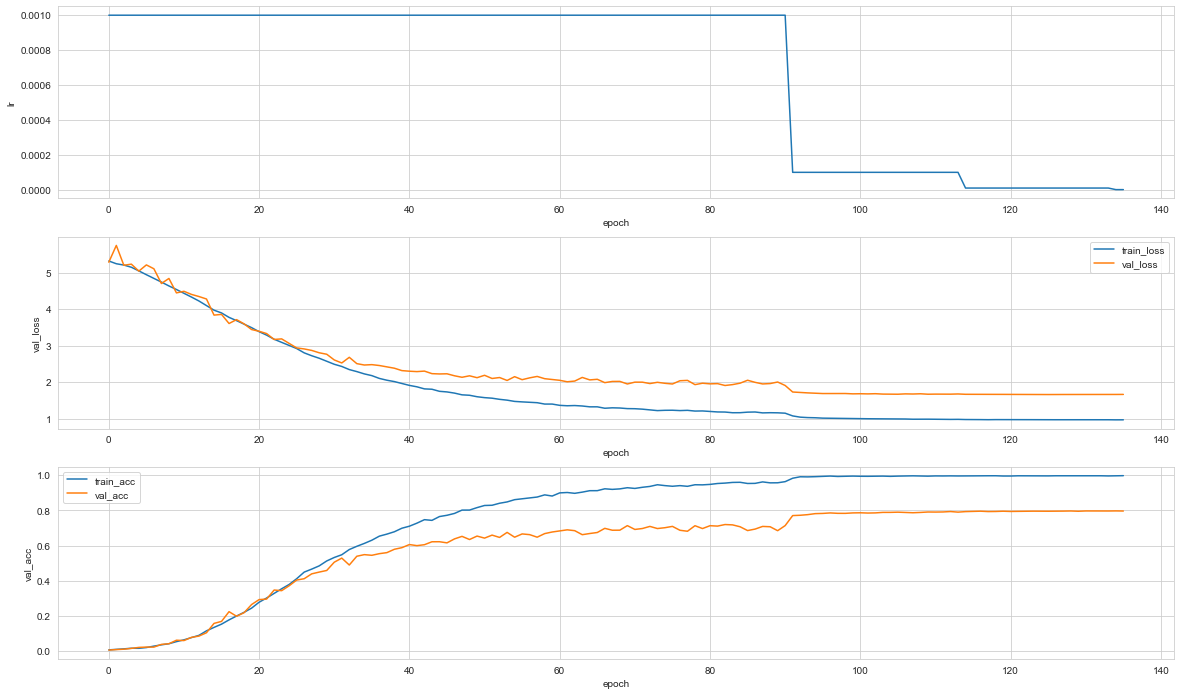

In [373]:
def single_experiment_plot(df):
    fig, ax = plt.subplots(3, 1, figsize=[20, 12])
    sns.lineplot(x='epoch', y='lr', data=df, ax=ax[0])
    sns.lineplot(x='epoch', y='train_loss', data=df, ax=ax[1], label='train_loss')
    sns.lineplot(x='epoch', y='val_loss', data=df, ax=ax[1], label='val_loss')
    sns.lineplot(x='epoch', y='train_acc', data=df, ax=ax[2], label='train_acc')
    sns.lineplot(x='epoch', y='val_acc', data=df, ax=ax[2], label='val_acc')
    plt.legend()
    return fig, ax

df = experiments_metrics[experiments_metrics.ex_id == 'SAN-459']
single_experiment_plot(df)

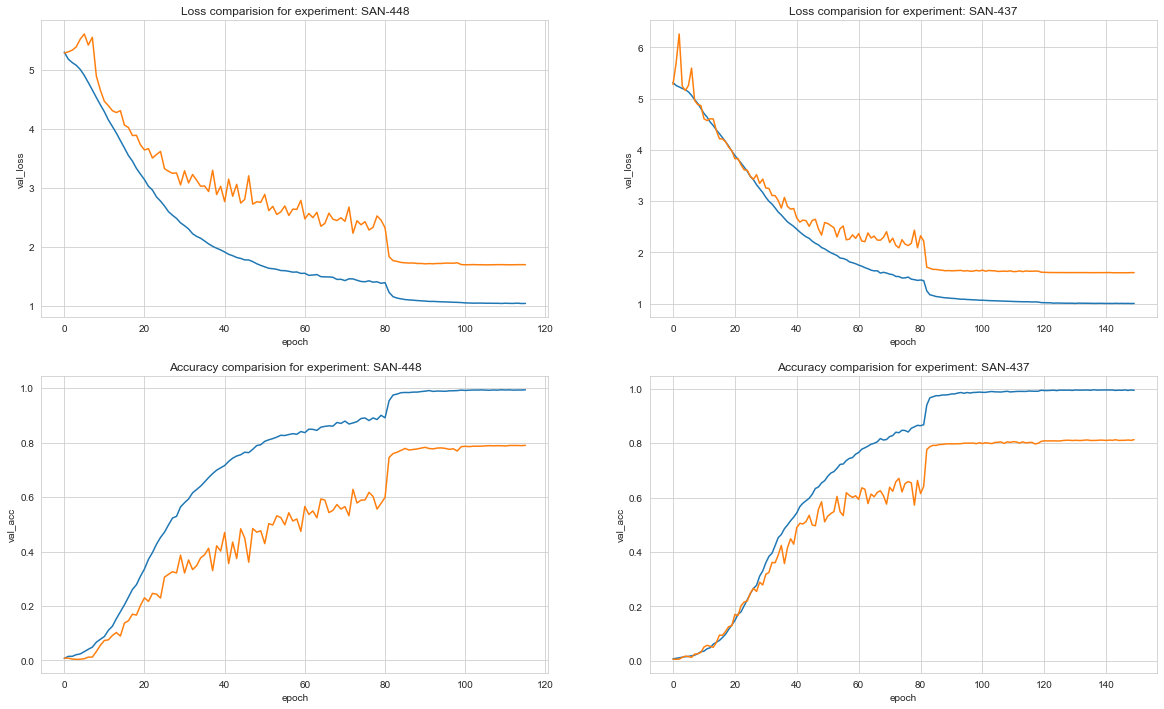

In [444]:
def fill_ax_for_data(df, ax, experiment_name):
    sns.lineplot(x='epoch', y='train_loss', data=df, ax=ax[0])
    sns.lineplot(x='epoch', y='val_loss', data=df, ax=ax[0])
    sns.lineplot(x='epoch', y='train_acc', data=df, ax=ax[1])
    sns.lineplot(x='epoch', y='val_acc', data=df, ax=ax[1])
    
    ax[0].title.set_text(f'Loss comparision for experiment: {experiment_name}')
    ax[1].title.set_text(f'Accuracy comparision for experiment: {experiment_name}')

fig, ax = plt.subplots(2, 2, figsize=[20, 12])
ex1, ex2 = 'SAN-448', 'SAN-437'
fill_ax_for_data(experiments_metrics[experiments_metrics.ex_id == ex1], ax[:, 0], experiment_name=ex1)
fill_ax_for_data(experiments_metrics[experiments_metrics.ex_id == ex2], ax[:, 1], experiment_name=ex2)

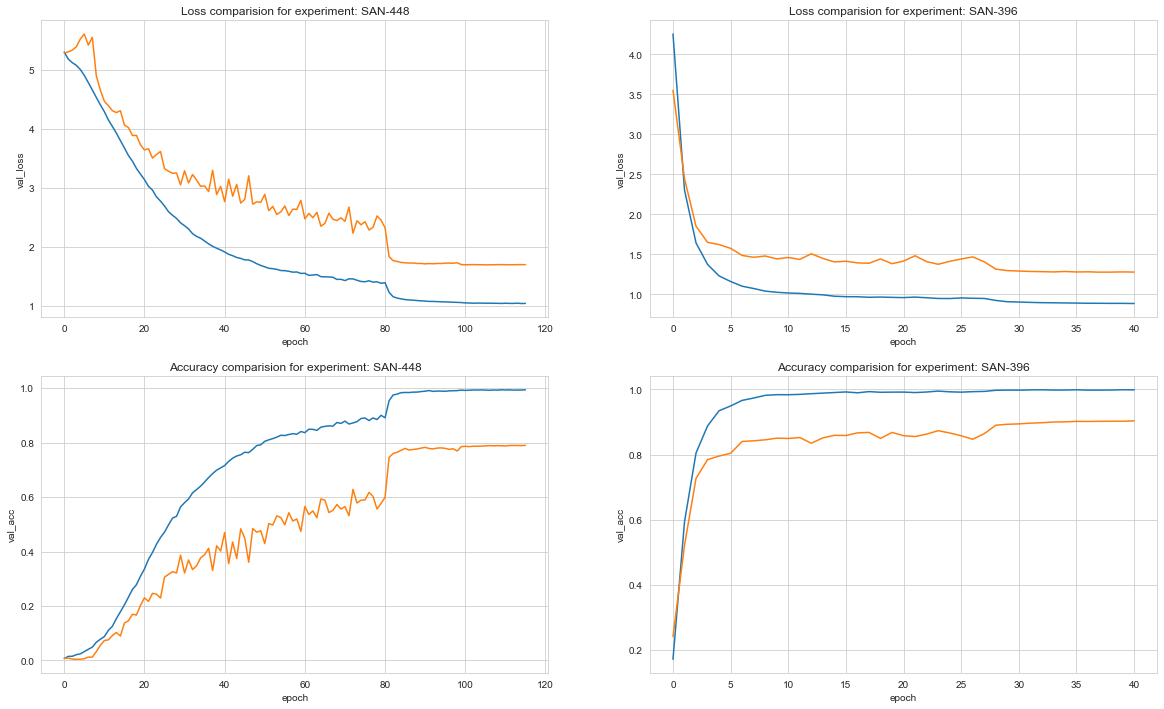

In [445]:
fig, ax = plt.subplots(2, 2, figsize=[20, 12])
ex1, ex2 = 'SAN-448', 'SAN-396'
fill_ax_for_data(experiments_metrics[experiments_metrics.ex_id == ex1], ax[:, 0], experiment_name=ex1)
fill_ax_for_data(experiments_metrics[experiments_metrics.ex_id == ex2], ax[:, 1], experiment_name=ex2)

Pretrained network results

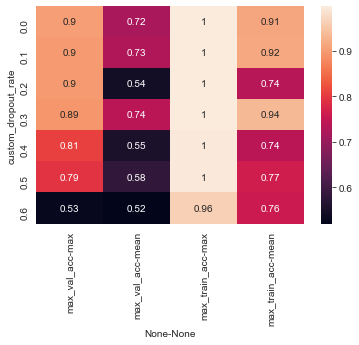

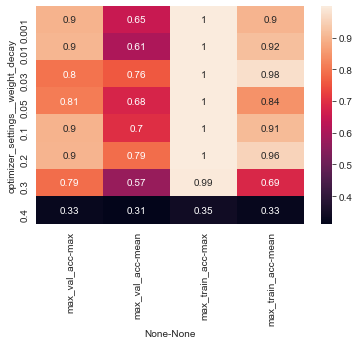

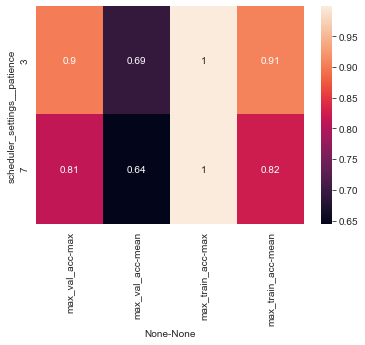

In [359]:
def single_setting_summary(settings, column, aggregations = ['max', 'mean']):
    df = settings.groupby(column).agg({'max_val_acc': aggregations, 'max_train_acc': aggregations})
    fig, ax = plt.subplots()
#     ax.get_xaxis().set_visible(False)

    sns.heatmap(df, annot=True)

def plot_setings(settings):
    for colname in ['custom_dropout_rate', 'optimizer_settings__weight_decay', 'scheduler_settings__patience']:
        single_setting_summary(settings, colname)


plot_setings(settings_summary)

In [381]:
settings_summary[settings_summary.index.isin(best_exp.values[0

array([[0.9031956791877748, 0.9985294342041016,
        "<class 'torch.optim.adamw.AdamW'>", '0.001', 3.0, 1.0, 0.0,
        'efficientnet-b0-82409404-fab3-11ea-bd84-2988f320ae9d', 0.01, 3,
        nan]], dtype=object)

In [401]:
def print_trial_settings(settings):
    for k in settings.keys():
        print(f'{k}:{settings[k][0]}')
    
def plot_best(experiments_metrics, settings_summary, channels_type):
    best_exp = experiments_metrics[experiments_metrics.val_acc == max(experiments_metrics.val_acc)][['ex_id']]
    best_exp_metrics = pd.merge(experiments_metrics, best_exp, on='ex_id')
    fig, ax = single_experiment_plot(best_exp_metrics)
    fig.suptitle(f'Best performing model for {channels_type=}. Experiment: {best_exp.values[0]}', size=16)
    print_trial_settings(settings_summary[settings_summary.index.isin(best_exp.values[0])]) 

def plot_summary_for_table(experiments_metrics, settings_summary, channels_type):
    plot_best(experiments_metrics, settings_summary, channels_type)
    
    experiments_settings = settings_summary[settings_summary.index.isin(experiments_metrics.ex_id.unique())] 
    plot_setings(experiments_settings)

# RGB

max_val_acc:0.9031956791877748
max_train_acc:0.9985294342041016
optimizer:<class 'torch.optim.adamw.AdamW'>
initial_lr:0.001
in_channels:3.0
load_weights:1.0
custom_dropout_rate:0.0
name:efficientnet-b0-82409404-fab3-11ea-bd84-2988f320ae9d
optimizer_settings__weight_decay:0.01
scheduler_settings__patience:3
scheduler_settings__factor:nan


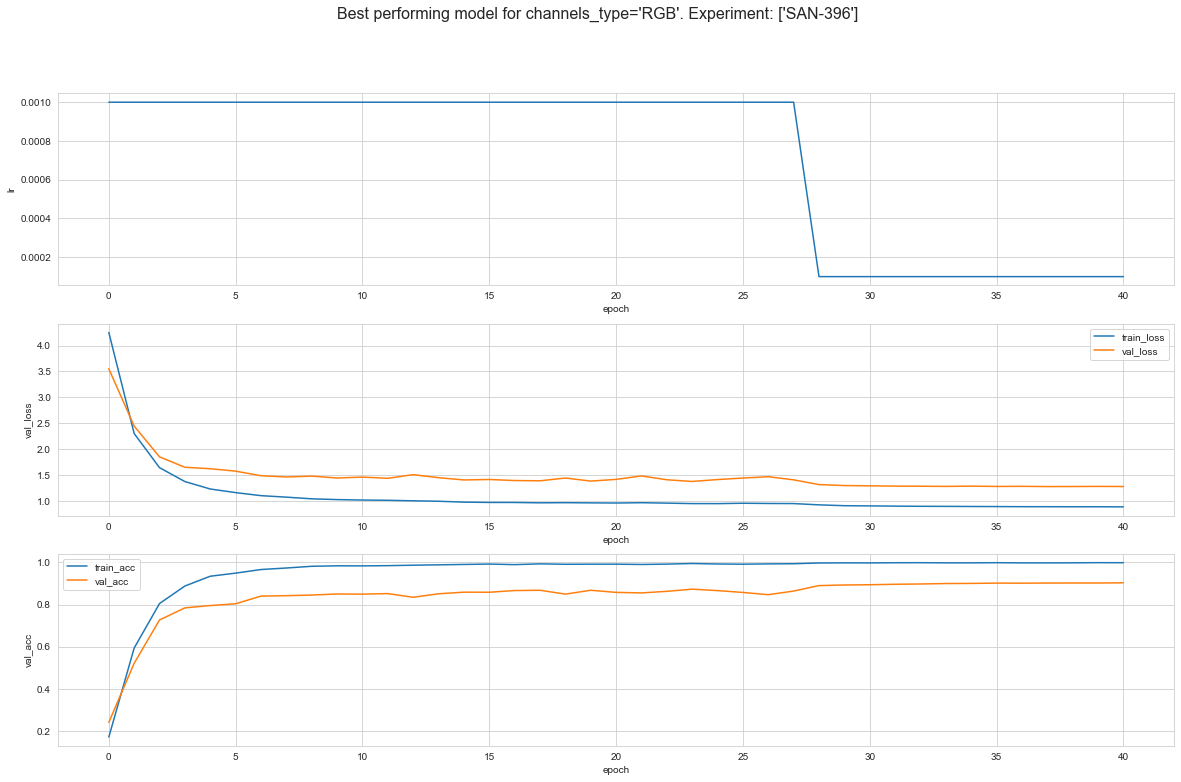

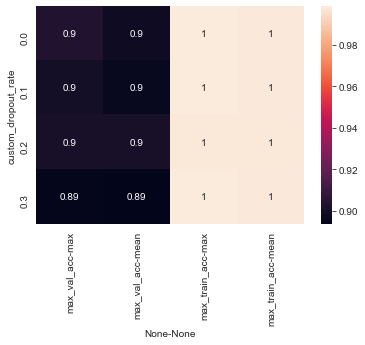

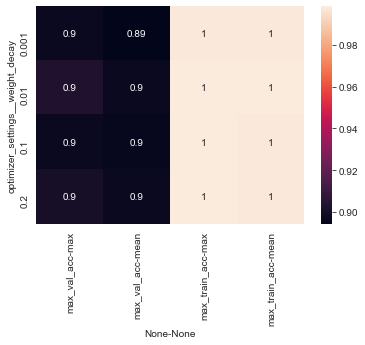

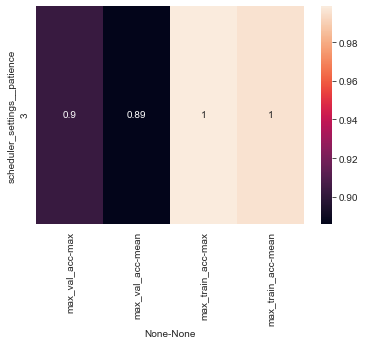

In [402]:
def subset_experiments(experiments_metrics, ids):
    return experiments_metrics[experiments_metrics.ex_id.isin(ids)]

rgb_trainings = subset_experiments(experiments_metrics, 
                                   ids=settings_summary[(settings_summary.in_channels == 3) & (settings_summary.load_weights > 0)].index)
plot_summary_for_table(rgb_trainings, settings_summary, channels_type = 'RGB')

# FROM SCRATCH, RGB

max_val_acc:0.7897878289222717
max_train_acc:0.9938725233078004
optimizer:<class 'torch.optim.adamw.AdamW'>
initial_lr:0.001
in_channels:3.0
load_weights:0.0
custom_dropout_rate:0.2
name:efficientnet-b0-2c7a42a8-fe6a-11ea-ad12-ab3860b636f8
optimizer_settings__weight_decay:0.3
scheduler_settings__patience:7
scheduler_settings__factor:nan


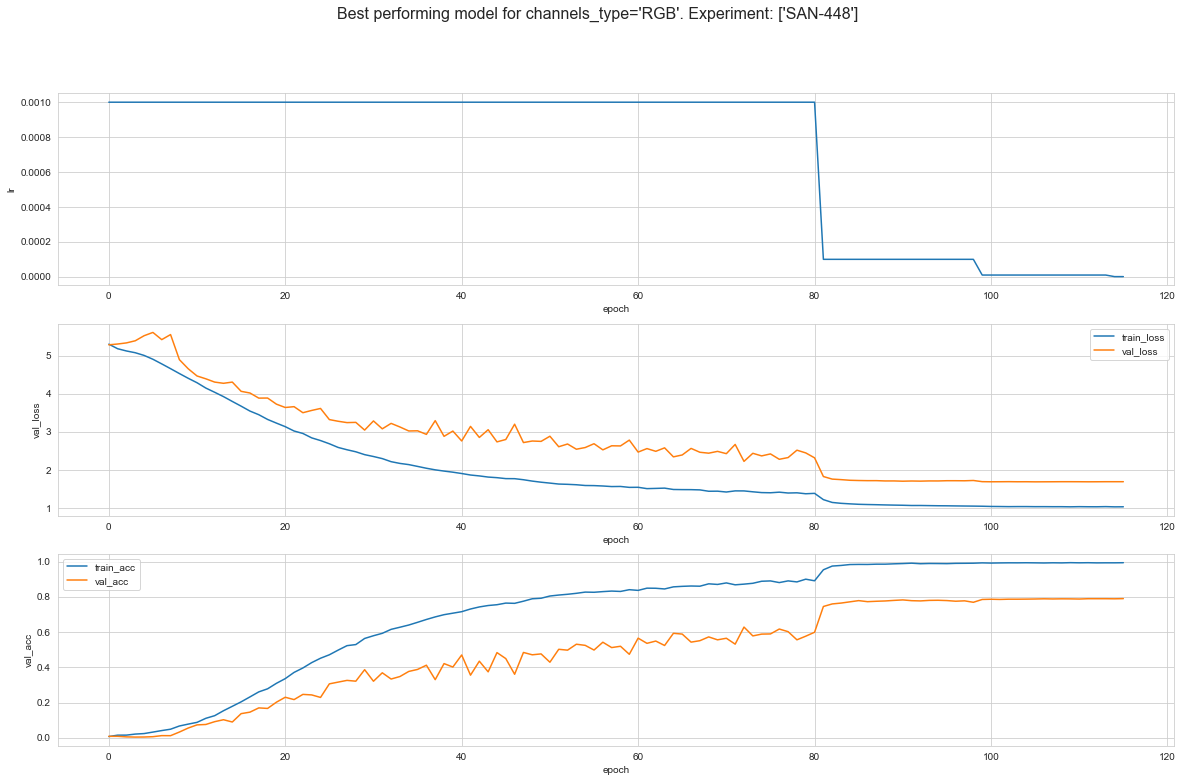

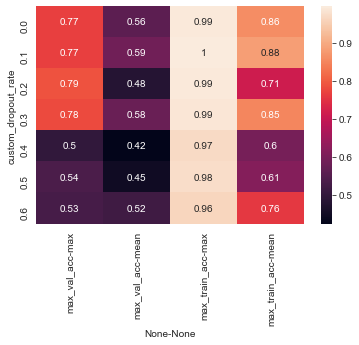

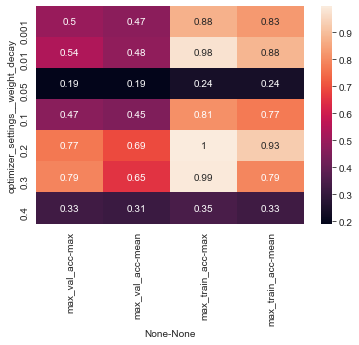

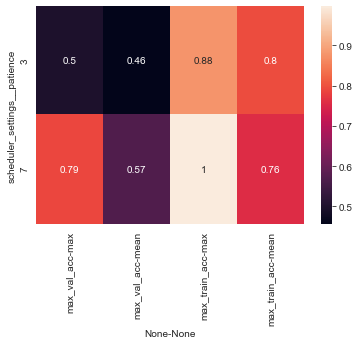

In [403]:
def subset_experiments(experiments_metrics, ids):
    return experiments_metrics[experiments_metrics.ex_id.isin(ids)]

rgb_trainings = subset_experiments(experiments_metrics, 
                                   ids=settings_summary[(settings_summary.in_channels == 3) & (settings_summary.load_weights == 0)].index)
plot_summary_for_table(rgb_trainings, settings_summary, channels_type = 'RGB')

# FROM SCRATCH, SINGLE CHANNEL

max_val_acc:0.8126240372657776
max_train_acc:0.9962009787559508
optimizer:<class 'torch.optim.adamw.AdamW'>
initial_lr:0.001
in_channels:1.0
load_weights:0.0
custom_dropout_rate:0.0
name:efficientnet-b0-7d67d4b1-fd8c-11ea-8bbb-001a7dda7112
optimizer_settings__weight_decay:0.1
scheduler_settings__patience:7
scheduler_settings__factor:nan


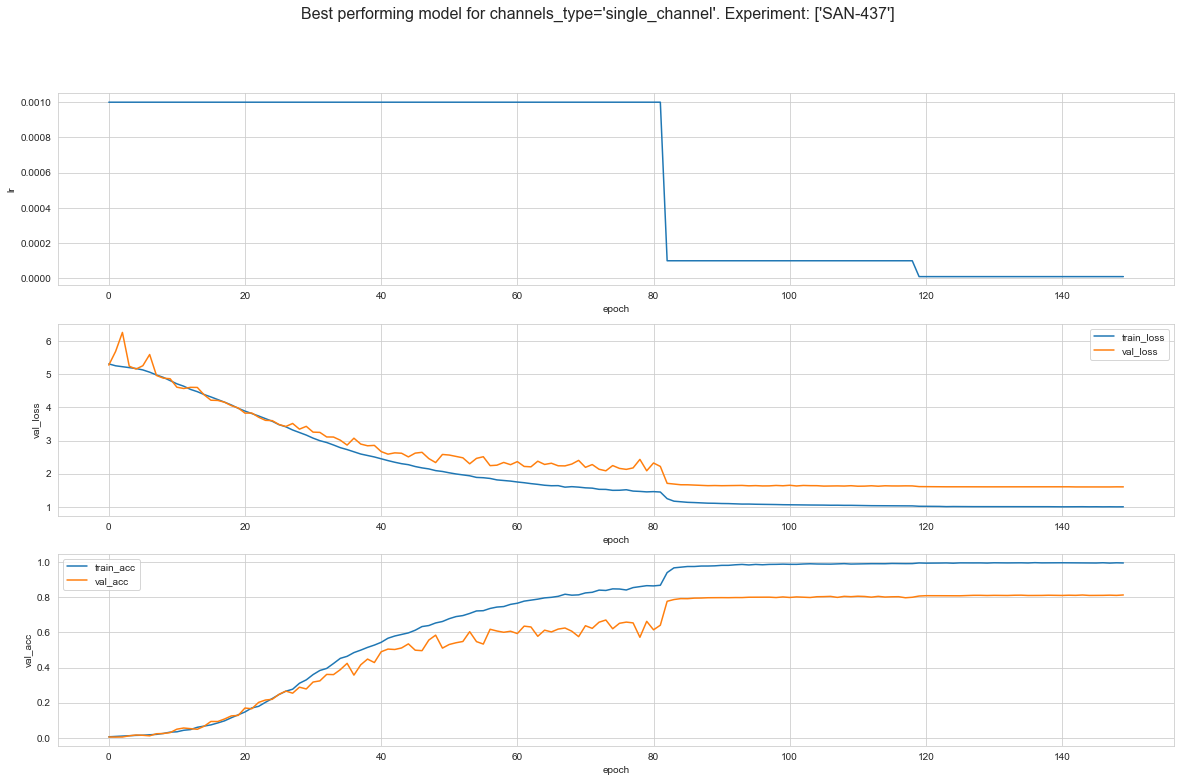

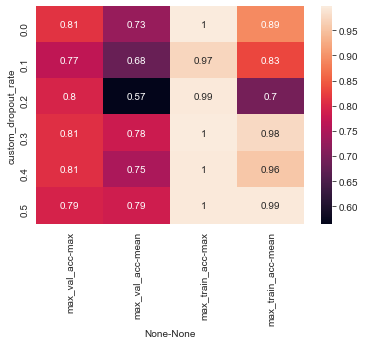

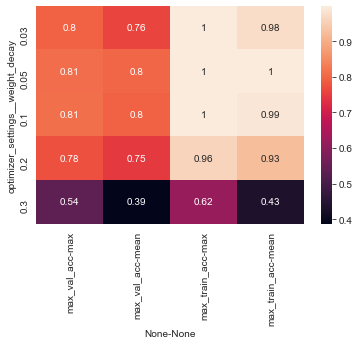

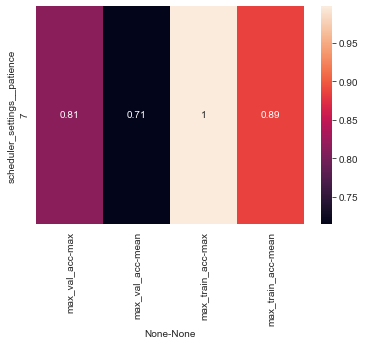

In [404]:
single_channel_trainings = subset_experiments(experiments_metrics, 
                                   ids=settings_summary[(settings_summary.in_channels == 1) & (settings_summary.load_weights == 0)].index)

plot_summary_for_table(single_channel_trainings, settings_summary, channels_type = 'single_channel')

In [443]:
import glob
import os

substring = 'val_predictions_efficientnet-b0'

results = annotations[annotations.test == 1][['relative_im_path']].copy().reset_index()

for ex_dir_name in experiments_best_score.index:
    try:
        ex_dir = neptune_out_dir / ex_dir_name
        file_path = Path([os.path.join(dp, f) for dp, dn, filenames in os.walk(ex_dir) for f in filenames if (substring in f)][0])

        predictions = pd.read_csv(str(file_path)).iloc[:,1:]
        results[ex_dir_name] = (predictions['class'] == predictions.pred)
        results[ex_dir_name] = results[ex_dir_name].astype(int)
    except:
        print(f'Error in {ex_dir_name}')

results.sort_index(axis=1, inplace=True)
results

Error in SAN-409
Error in SAN-430
Error in SAN-470
Error in SAN-454


,SAN-392,SAN-393,SAN-394,SAN-395,SAN-396,SAN-397,SAN-398,SAN-399,SAN-400,SAN-401,...,SAN-465,SAN-466,SAN-467,SAN-468,SAN-469,SAN-471,SAN-472,SAN-473,index,relative_im_path
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,45,car_ims/000046.jpg
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,46,car_ims/000047.jpg
2,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,47,car_ims/000048.jpg
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,48,car_ims/000049.jpg
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,49,car_ims/000050.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8036,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,16180,car_ims/016181.jpg
8037,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,0,1,1,1,16181,car_ims/016182.jpg
8038,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,16182,car_ims/016183.jpg
8039,1,1,1,0,0,0,0,0,0,0,...,0,1,0,1,0,1,1,1,16183,car_ims/016184.jpg


<AxesSubplot:>

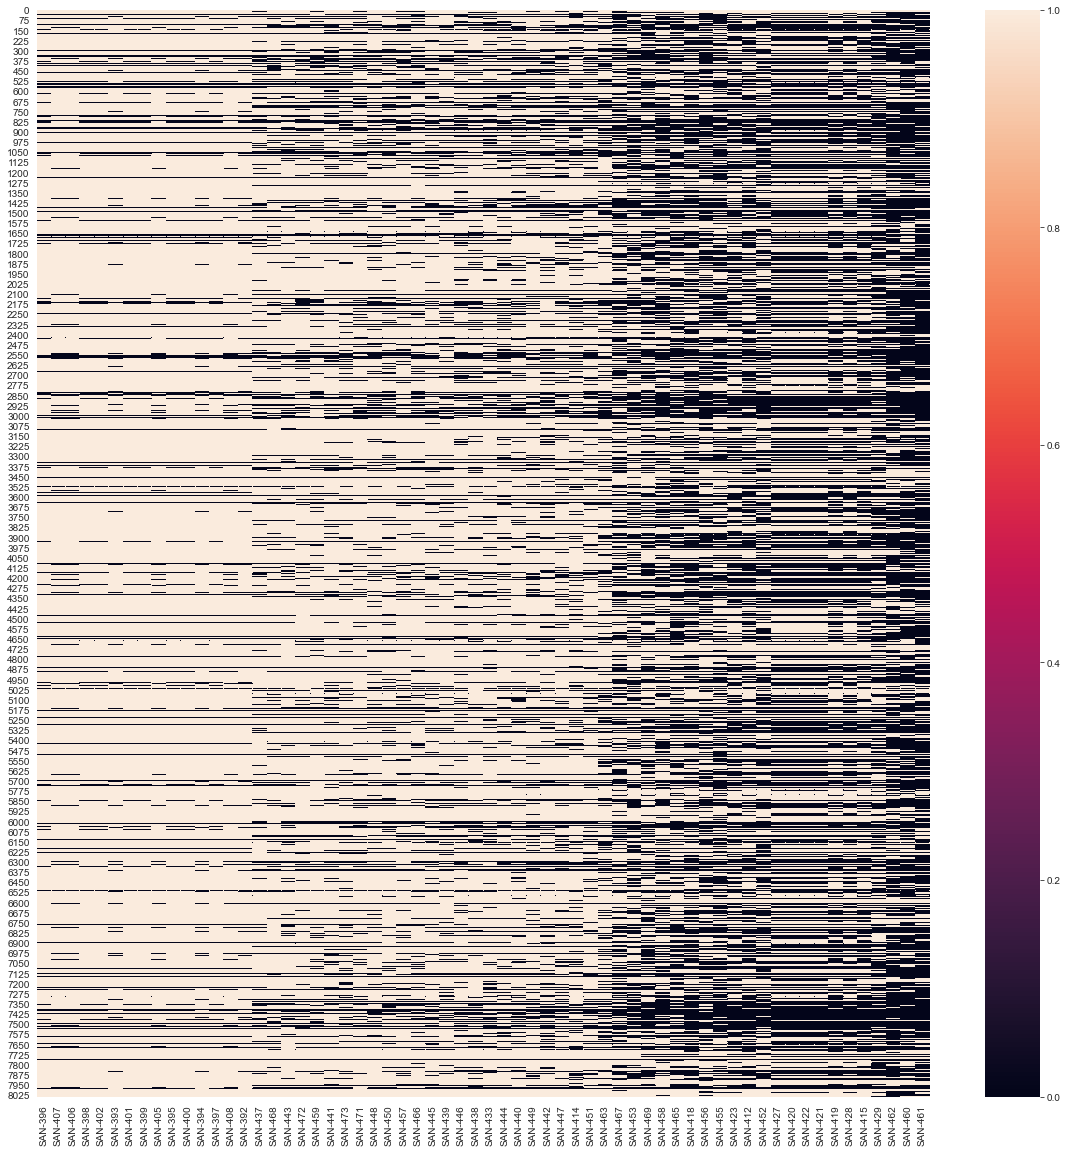

In [439]:
fig, ax = plt.subplots(figsize=[20, 20])
sns.heatmap(results.iloc[:, 2:])